In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i - 127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-03f004c5291f580c.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e4d1bc770bb4c72e.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f3c2638206a5e78a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-819c8d4ea96c983d.arrow


((2000, 3, 64, 64), -1.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(31, torch.Size([64, 3, 64, 64]))

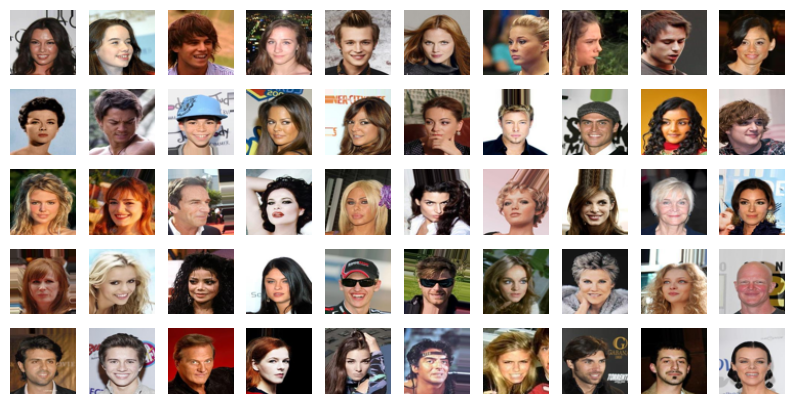

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
cls = torch.nn.Sequential(
    torch.nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid(),
)

cls(torch.randn(2, 3, 64, 64)).shape

torch.Size([2, 1])

In [5]:
def block(in_channels,
          out_channels,
          kernel_size=5,
          stride=2,
          padding=1,
          dropout=True):

    sequential = [
        torch.nn.Conv2d(in_channels=in_channels,
                        out_channels=in_channels,
                        kernel_size=3,
                        stride=1,
                        padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.ConvTranspose2d(in_channels=in_channels,
                                 out_channels=out_channels,
                                 kernel_size=kernel_size,
                                 stride=stride,
                                 padding=padding),
        torch.nn.BatchNorm2d(num_features=out_channels),
        torch.nn.LeakyReLU(),
    ]

    if dropout:
        sequential.append(torch.nn.Dropout(p=0.2))

    return torch.nn.Sequential(*sequential)


gen = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=512 * 4 * 4),
    torch.nn.BatchNorm1d(num_features=512 * 4 * 4),
    torch.nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),
    block(512, 256),
    block(256, 128),
    block(128, 64),
    block(64, 3, dropout=False),
    torch.nn.UpsamplingNearest2d(size=64),
    torch.nn.Conv2d(in_channels=3,
                    out_channels=3,
                    kernel_size=1,
                    stride=1,
                    padding=0),
    torch.nn.Tanh(),
)

gen(torch.randn(2, 784)).shape

torch.Size([2, 3, 64, 64])

In [6]:
def set_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad_(requires_grad)


criterion = torch.nn.BCELoss()
optimizer_cls = torch.optim.Adam(cls.parameters(), lr=2e-4)
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=2e-4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cls.to(device)
gen.to(device)

cls.train()
gen.train()

device

'cuda'

In [7]:
def train_cls():

    def update(data, label):
        pred = cls(data)
        label = torch.full((64, 1), label, device=device).float()
        loss = criterion(pred, label)

        loss.backward()
        optimizer_cls.step()
        optimizer_cls.zero_grad()

        return loss.item()

    set_requires_grad(cls, True)
    set_requires_grad(gen, False)

    with torch.no_grad():
        data = gen(torch.randn(64, 784, device=device))

    loss_sum = update(data, 0)

    data = next(iter(loader)).to(device)
    loss_sum += update(data, 1)

    return loss_sum


train_cls()

1.4076711535453796

In [8]:
def train_gen():
    set_requires_grad(cls, False)
    set_requires_grad(gen, True)

    pred = cls(gen(torch.randn(64, 784, device=device)))

    loss = criterion(pred, torch.ones(64, 1, device=device))
    loss.backward()
    optimizer_gen.step()
    optimizer_gen.zero_grad()

    return loss.item()


train_gen()

0.7130489349365234

0 1.3884376883506775 0.7115840911865234


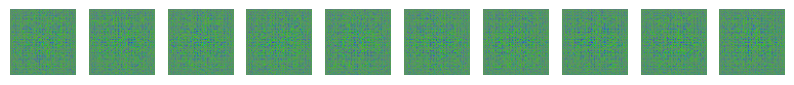

5000 0.004217172972857952 5.159452438354492


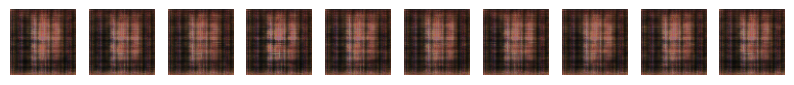

10000 0.041801201179808345 5.353414535522461


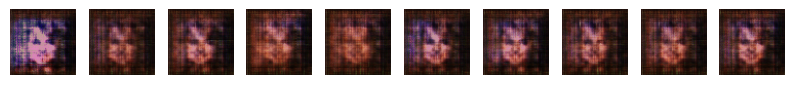

15000 0.04242597706615925 6.837029457092285


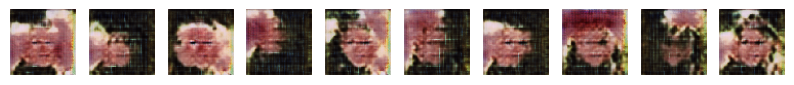

20000 0.33639584481716156 3.846566677093506


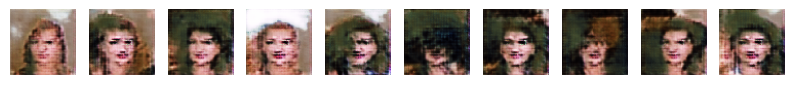

25000 0.17930898070335388 4.528997421264648


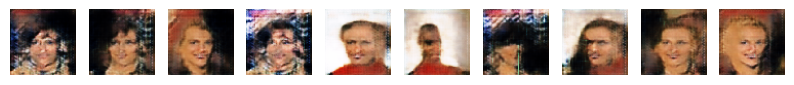

30000 0.2544855922460556 4.656222343444824


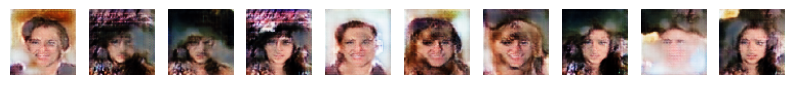

35000 0.20251230150461197 4.864853858947754


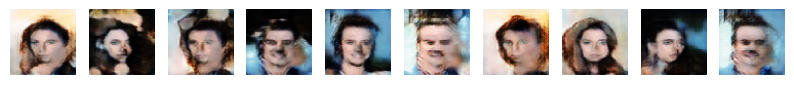

40000 0.19664611667394638 5.414936065673828


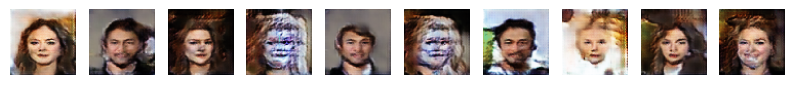

45000 0.2664935439825058 5.039531707763672


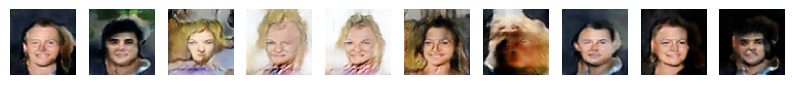

50000 0.10249171033501625 4.005534648895264


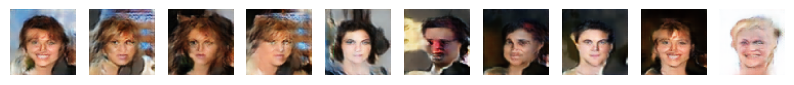

55000 0.1996816247701645 6.131958961486816


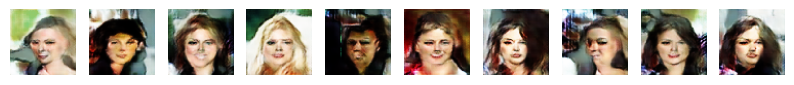

60000 0.16480427980422974 6.097893714904785


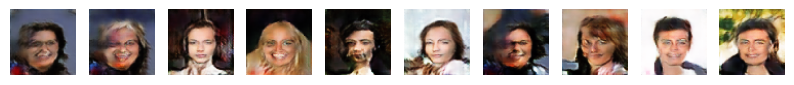

65000 0.04696076922118664 5.977357387542725


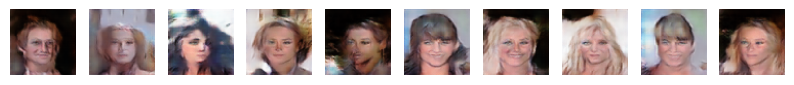

70000 0.05730561725795269 6.6909918785095215


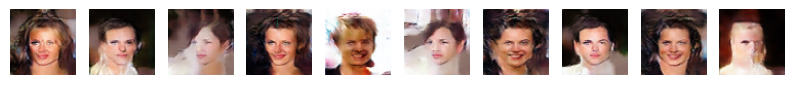

75000 0.17901887372136116 5.358396530151367


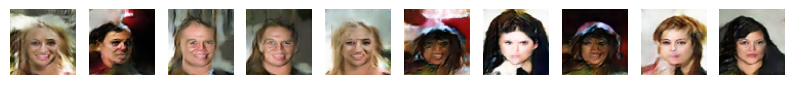

80000 0.13884370401501656 5.544503688812256


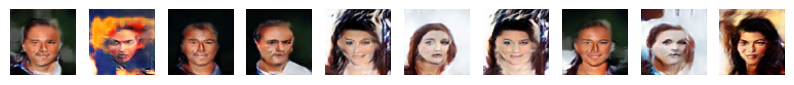

85000 0.16025634482502937 6.360744476318359


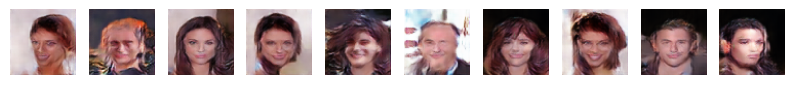

90000 0.251024030148983 6.522707939147949


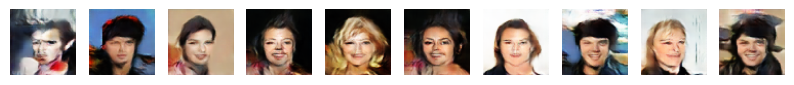

95000 0.18213753402233124 5.788028240203857


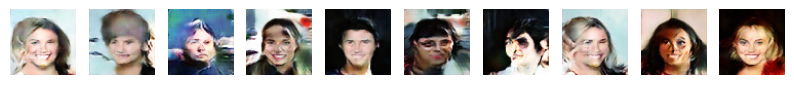

In [9]:
def train():
    for epoch in range(10_0000):
        loss_cls = train_cls()
        loss_gen = train_gen()

        if epoch % 5000 == 0:
            print(epoch, loss_cls, loss_gen)
            with torch.no_grad():
                pred = gen(torch.randn(10, 784, device=device))
            show(pred)


local_training = True

if local_training:
    train()

In [10]:
from transformers import PreTrainedModel, PretrainedConfig


class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.cls = cls.to('cpu')
        self.gen = gen.to('cpu')


if local_training:
    #保存训练好的模型到hub
    Model(PretrainedConfig()).push_to_hub(
        repo_id='lansinuote/gen.3.dcgan',
        use_auth_token=open('/root/hub_token.txt').read().strip())

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/59.7M [00:00<?, ?B/s]

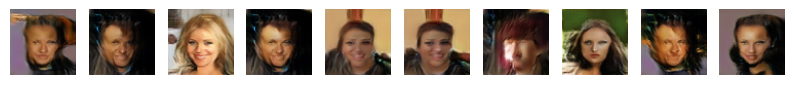

In [11]:
#加载训练好的模型
gen = Model.from_pretrained('lansinuote/gen.3.dcgan').gen

with torch.no_grad():
    pred = gen(torch.randn(10, 784))

show(pred)